In [1]:
# !pip install dotenv
# !pip install pygraphviz

In [2]:
from typing import TypedDict, List, Annotated
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv
import operator, os
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
load_dotenv()
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [4]:
tool = TavilySearchResults(tavily_api_key=TAVILY_API_KEY,max_results=3)

C:\Users\Digital Technologies\AppData\Local\Temp\ipykernel_9132\159487971.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(tavily_api_key=TAVILY_API_KEY,max_results=3)


In [5]:
class AgentState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add]

In [6]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

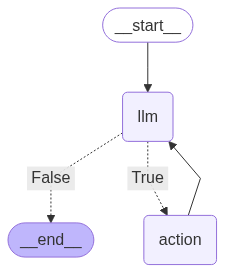

In [9]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_mermaid_png())

In [10]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})
result

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_YiLNsi4zATUGb9wpcT5OlHED', 'type': 'tool_call'}
Back to the model!


{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YiLNsi4zATUGb9wpcT5OlHED', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C705VpYGBH09MH08kyDlDIKkLxmHE', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--00356f14-7707-4f50-b13b-f7c19aaa680e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, '

In [11]:
result['messages'][-1].content

'The weather in San Francisco for August 2025 ranges from a minimum temperature of 6.8°C (44.2°F) to a maximum temperature of 23.1°C (73.6°F). There is also information about precipitation levels and historical weather data available. If you would like more specific details or current weather information, please let me know.'

In [14]:
messages = [HumanMessage(content="What is the weather in SF and LA ?")]
result = abot.graph.invoke({"messages": messages})
result['messages'][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_cmPgnDyBdbK2hkfvNym42HZS', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_hGc3JMBFCh3R2nc2auvfdX2O', 'type': 'tool_call'}
Back to the model!


'The weather in San Francisco for August 2025 shows a maximum temperature ranging from 13.9°C (57.1°F) to 23.1°C (73.6°F), with precipitation levels varying throughout the month. You can find more detailed information about the weather in San Francisco on [Climate-Data.org](https://en.climate-data.org/north-america/united-states-of-america/california/san-francisco-385/t/august-8/).\n\nOn the other hand, Los Angeles is experiencing hot weather in August 2025 with average temperatures between 69°F and 87°F. The weather varies from sunny days to partly cloudy and even patchy rain. For further details, you can visit [Weather25.com](https://www.weather25.com/north-america/usa/california/los-angeles?page=month&month=August).'

In [15]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_yykzeyFXg9K8Y2dbESCBwDRn', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_Nd6VmYdUFvOd96Zifl5iU3tK', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri 2024'}, 'id': 'call_lxKRAT4YNfO8hzvdFsUA6gP8', 'type': 'tool_call'}
Back to the model!


In [16]:
print(result['messages'][-1].content)

1. The Kansas City Chiefs won the Super Bowl in 2024.

2. The headquarters of the Kansas City Chiefs is located in Kansas City, Missouri.

3. The GDP of Missouri in 2023 was approximately $348.49 billion in inflation-adjusted (chained 2017) dollars, according to estimates from the U.S. Bureau of Economic Analysis. The data for 2024 would likely be slightly higher, considering the trend of a 1.9 percent increase from 2022 to 2023.
